# CS4487 - Tutorial 8: Non-Linear Dimensionality Reduction and Face Recognition

In this tutorial you will use non-linear dimensionality reduction on face images, and then train a classifier for face recognition. 

First we need to initialize Python.  Run the below cell.

In [2]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
# IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import joblib
from numpy import *
from sklearn import *
import glob
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
random.seed(100)
rbow = plt.get_cmap('rainbow')

## Loading Data and Pre-processing
We first need to load the images.  We will use the same dataset as Tutorial 7. Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [3]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show all the images!

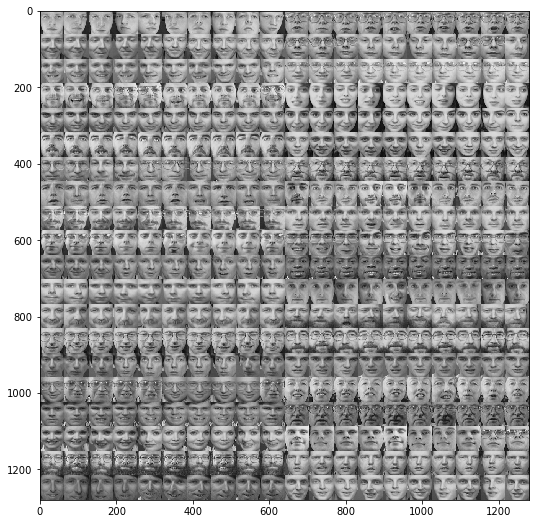

In [4]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. Now we split the data into training and testing sets.

In [5]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


## Non-Linear Dimensionality Reduction - KPCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use KPCA to reduce the dimension first and then use the KPCA weights as the representation for each image.  Run KPCA on the data using **10** principal components.  Use the RBF kernel with gamma=0.001.

In [6]:
### INSERT YOUR CODE HERE
## HINT
# 1. decomposition.KernelPCA(n_components= , kernel= , gamma= , n_jobs= )

kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001, n_jobs=-1)
KPCATrainX = kpca.fit_transform(trainX)
KPCATestX = kpca.transform(testX)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [7]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

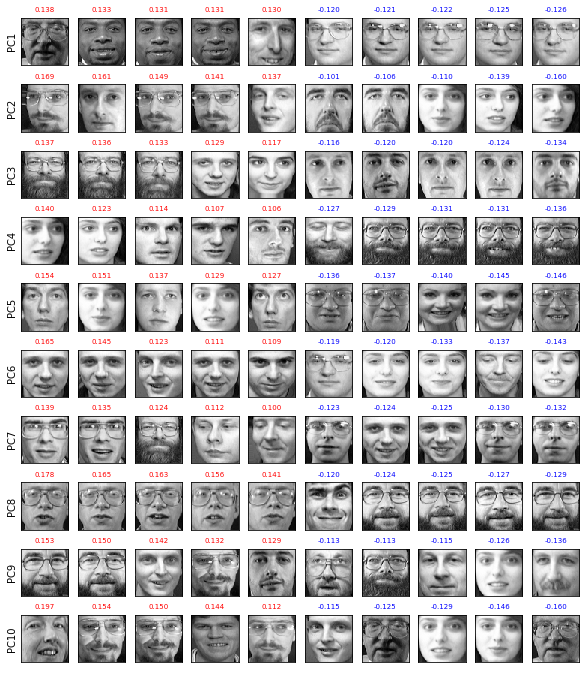

In [8]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- **We can see the nonlinearity of KPCA here, different PCs prefer different features for example basis of PC6 have positive values for the faces that have wide opened eyes and negative values for faces with glasses or closed half-opened eyes.**

### Face Recognition
Now train a logistic classifier to do the face recognition.  Use the calculated KPCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components or kernel hyperparameters.  Calculate the average training and testing accuracies.  Remember to transform the test data into the KPCA representation too!


In [9]:
### INSERT YOUR CODE HERE
## HINT 
# 1. linear_model.LogisticRegressionCV(Cs= , cv= , n_jobs= )
# 2. acc = metrics.accuracy_score( , )

model = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 20), cv=5, n_jobs=-1)
model.fit(KPCATrainX, trainY)
predict = model.predict(KPCATestX)

C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [10]:
testAccuracy = metrics.accuracy_score(predict, testY)
testAccuracy2 = model.score(KPCATestX, testY)
trainAccuracy = model.score(KPCATrainX, trainY)

print("The Training accuracy of KPCA is {}".format(trainAccuracy))
print("The Test accuracy of KPCA is {}".format(testAccuracy2))

The Training accuracy of KPCA is 0.98125
The Test accuracy of KPCA is 0.8375


## Non-Linear Dimensionality Reduction - ICA

Next, we will use ICA to reduce the dimension.

- Applying the ICA with **20** principal components as the representation for each image. 
- Using the calculated ICA representation to  train a logistic classifier to do the face recognition. 
- Calculating the average training and testing accuracies. 

In [11]:
### INSERT YOUR CODE HERE
## HINT
# 1. decomposition.FastICA(n_components=  )
# 2. linear_model.LogisticRegressionCV(Cs= , cv= , n_jobs= )

ica = decomposition.FastICA(n_components=20)
ICATrainX = ica.fit_transform(trainX)
ICATestX = ica.transform(testX)

icaModel = linear_model.LogisticRegressionCV(Cs=logspace(-4.0, 4.0, 20), cv=5, n_jobs=-1)
icaModel.fit(ICATrainX, trainY)

C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegressionCV(Cs=array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [12]:
trainAccuracy = icaModel.score(ICATrainX, trainY)
testAccuracy = icaModel.score(ICATestX, testY)

print("The Training accuracy of ICA is {}".format(trainAccuracy))
print("The Test accuracy of ICA is {}".format(testAccuracy))

The Training accuracy of ICA is 1.0
The Test accuracy of ICA is 0.925


## Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy using KPCA.  Train a logistic classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

In [13]:
### INSERT YOUR CODE HERE

gammas = [0.0001, 0.0005, 0.001, 0.005, 0.01]
ncs = [5, 10, 15, 20, 25, 30]
degrees = [1, 2, 3, 4, 5]

trainacc_rbf = zeros((len(gammas), len(ncs)))
testacc_rbf = zeros((len(gammas), len(ncs)))

print("RBF Kernel\ngammas, n: Training Accuracy, Test Accuracy")

for i, ga in enumerate(gammas):
    for j, nc in enumerate(ncs):
        
        # Fit & transform
        rbfKPCA = decomposition.KernelPCA(n_components=nc, kernel='rbf', gamma=ga, n_jobs=-1)
        rbfTrainX = rbfKPCA.fit_transform(trainX)
        rbfTestX = rbfKPCA.transform(testX)
        
        # Train a model
        rbfModel = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
        rbfModel.fit(rbfTrainX, trainY)

        # Predict and score
        predYTrain = rbfModel.predict(rbfTrainX)
        predYTest = rbfModel.predict(rbfTestX)
        
        trainacc_rbf[i,j] = metrics.accuracy_score(trainY, predYTrain)
        testacc_rbf[i,j]  = metrics.accuracy_score(testY, predYTest)

        print(f"{ga}, {nc} : {trainacc_rbf[i,j]}, {testacc_rbf[i,j]}")

RBF Kernel
gammas, n: Training Accuracy, Test Accuracy


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\utils\extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0001, 5 : 0.81875, 0.575


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\utils\extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0001, 10 : 0.975, 0.8125


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\utils\extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0001, 15 : 1.0, 0.9


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0001, 20 : 1.0, 0.925


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0001, 25 : 1.0, 0.9625


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0001, 30 : 1.0, 0.9375


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0005, 5 : 0.821875, 0.575


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0005, 10 : 0.98125, 0.825


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0005, 15 : 1.0, 0.9


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0005, 20 : 1.0, 0.925


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0005, 25 : 1.0, 0.9625


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0005, 30 : 1.0, 0.95


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\utils\extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.001, 5 : 0.85, 0.5875


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.001, 10 : 0.98125, 0.8375


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.001, 15 : 1.0, 0.8875
0.001, 20 : 1.0, 0.9375


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.001, 25 : 1.0, 0.9625


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.001, 30 : 1.0, 0.9625


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.005, 5 : 0.796875, 0.5125


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.005, 10 : 0.984375, 0.775
0.005, 15 : 1.0, 0.9


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.005, 20 : 1.0, 0.9125
0.005, 25 : 1.0, 0.925
0.005, 30 : 1.0, 0.9375


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.01, 5 : 0.796875, 0.6


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.01, 10 : 0.99375, 0.85


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.01, 15 : 1.0, 0.9
0.01, 20 : 1.0, 0.8875
0.01, 25 : 1.0, 0.9
0.01, 30 : 1.0, 0.925


In [16]:
degrees = [1,2,3,4,5]
trainacc_poly = zeros((len(degrees), len(ncs)))
testacc_poly  = zeros((len(degrees), len(ncs)))

for i,d in enumerate(degrees):
    print(d)
    kpca = decomposition.KernelPCA(n_components=nc, kernel='poly', degree=d, n_jobs=-1)
    trainW = kpca.fit_transform(trainX)
    testW  = kpca.transform(testX)

    for j,K in enumerate(ncs):
        trainWx = trainW[:,0:K]
        testWx  = testW[:,0:K]
        
        logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=3, n_jobs=-1)
        logreg.fit(trainWx, trainY)

        # predict from the model
        predYtrain = logreg.predict(trainWx)
        predYtest  = logreg.predict(testWx)

        # calculate accuracy
        trainacc_poly[i,j] = metrics.accuracy_score(trainY, predYtrain)
        testacc_poly[i,j]  = metrics.accuracy_score(testY, predYtest)
    print(testacc_poly[i,:])

1


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

[0.575  0.825  0.9    0.9125 0.9625 0.95  ]
2


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

[0.5625 0.825  0.9    0.9375 0.9625 0.9625]
3


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

[0.55   0.85   0.9    0.9375 0.9625 0.9625]
4


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

[0.525  0.85   0.9    0.9375 0.9625 0.9625]
5


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\utils\extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

[0.55   0.85   0.925  0.9375 0.95   0.9625]


C:\Users\Muhammad Usman\Anaconda3\envs\qc\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


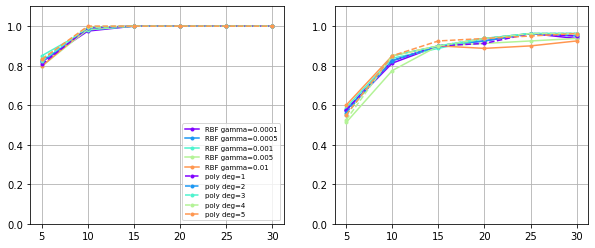

In [17]:
trainacc = trainacc_rbf
testacc = testacc_rbf

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for i,gamma in enumerate(gammas):
    plt.plot(ncs, trainacc[i,:], '.-', color=rbow(float(i)/len(gammas)), label="RBF gamma="+str(gamma))
for i,d in enumerate(degrees):
    plt.plot(ncs, trainacc_poly[i,:], '.--', color=rbow(float(i)/len(degrees)), label="poly deg="+str(d))
plt.ylim(0,1.1)    

plt.legend(loc="lower right", fontsize=7)
plt.grid(True)
plt.subplot(1,2,2)
for i,gamma in enumerate(gammas):
    plt.plot(ncs, testacc[i,:], '.-', color=rbow(float(i)/len(gammas)))
for i,d in enumerate(degrees):
    plt.plot(ncs, testacc_poly[i,:], '.--', color=rbow(float(i)/len(degrees)))
plt.ylim(0,1.1)    
    
plt.grid(True)

_What is the best kernel and number of components?  View the prototypes for each compenent to see what they look like_
- **Both Poly and RBF seem to give same results with Poly best at degree 1 and 25 components and RBF best at Gamma 0.0001 and 25 Componenets.**

In [20]:
### INSERT YOUR CODE HERE
## HINT
# 1. ii = unravel_index(argmax(testacc), testacc.shape)
# 2. gamma = gammas[ii[0]]
# 3. plot_kbasis(kpca, imgsize, trainX)

li = unravel_index(argmax(testacc_rbf), testacc_rbf.shape)
bestGamma = gammas[li[0]]
print("Best Gamma and Test Accuracy for RBF: ", bestGamma, testacc_rbf[li[0],li[1]])

Best Gamma and Test Accuracy for RBF:  0.0001 0.9625


In [21]:
ii = unravel_index(argmax(testacc_poly), testacc_poly.shape)
bestDegree = degrees[ii[0]]
print("Best Degree and Test Accuracy for Poly: ", bestDegree, testacc_poly[ii[0],ii[1]])

Best Degree and Test Accuracy for Poly:  1 0.9625


<Figure size 1008x1296 with 0 Axes>

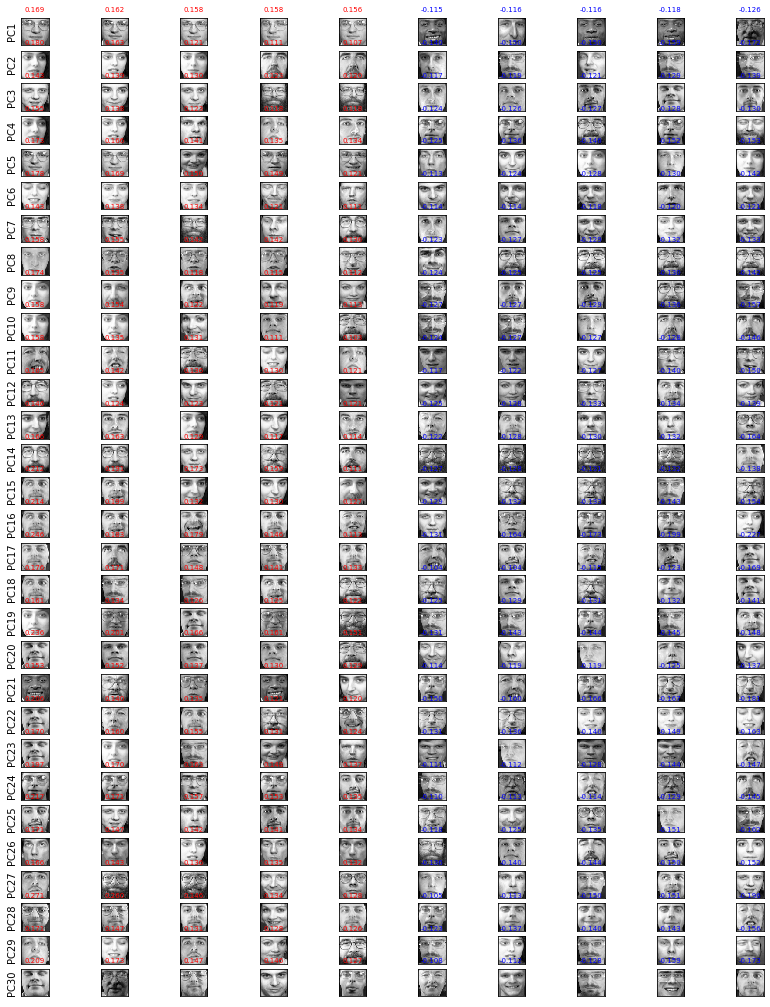

In [23]:
plt.figure(figsize=(14, 18))
plot_kbasis(kpca, imgsize, trainX)